**Mesure de régularité**

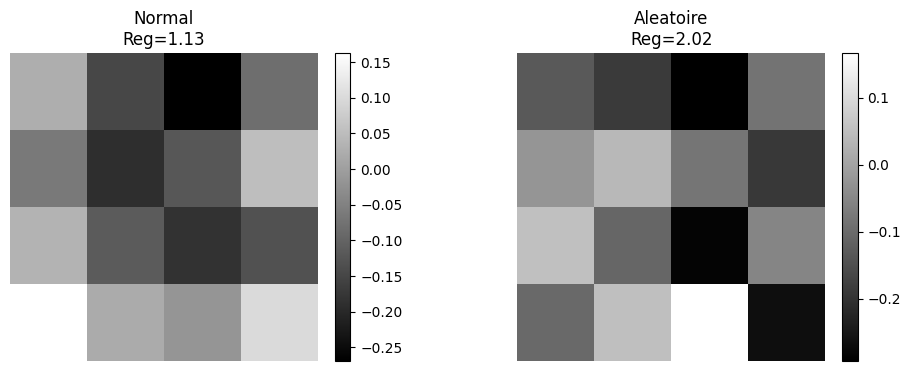

In [23]:
import numpy as np
import matplotlib.pyplot as plt
h = [[ 0.02439906, -0.14774486, -0.26901716, -0.08239703],
       [-0.06463236, -0.19133082, -0.12083958,  0.05277538],
       [ 0.0339999 , -0.11513419, -0.18441156, -0.13106574],
       [ 0.16250205,  0.02085505, -0.0163816 ,  0.09919927]]
h = np.array(h)
h_random = np.random.uniform(-0.30, 0.20, (4, 4))

def regularity_fourier(h, alpha=1):
    """
    Calcule la régularité d'un filtre 2D h[n,m] via sa transformée de Fourier.
    """
    H = np.fft.fft2(h)
    H = np.fft.fftshift(H)  # recentrer les basses fréquences
    
    n, m = h.shape
    u = np.fft.fftshift(np.fft.fftfreq(n))
    v = np.fft.fftshift(np.fft.fftfreq(m))
    U, V = np.meshgrid(u, v, indexing='ij')
    
    freq_weight = (U**2 + V**2)**(alpha/2)
    reg = np.sum(freq_weight * np.abs(H)**2)
    return reg

# Création de filtres d'exemple
filters = {
    "Normal": h,
    "Aleatoire": h_random
}

# Calcul des régularités
regularities = {name: regularity_fourier(h) for name, h in filters.items()}

# Affichage
fig, axes = plt.subplots(1, len(filters), figsize=(12,4))
for ax, (name, h) in zip(axes, filters.items()):
    im = ax.imshow(h, cmap='gray', interpolation='nearest')
    ax.set_title(f"{name}\nReg={regularities[name]:.2f}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator

def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique bilinéaire pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return X, Y, Zsmooth

def project_to_schwartz(Zsmooth, sigma=None):
    """Projette un filtre interpolé dans un espace proche de S(R^2) via une fenêtre gaussienne"""
    H, W = Zsmooth.shape
    if sigma is None:
        sigma = min(H, W) / 2
    y = np.arange(H) - H/2
    x = np.arange(W) - W/2
    X, Y = np.meshgrid(x, y)
    gauss_window = np.exp(-(X**2 + Y**2) / (2*sigma**2))
    Z_schwartz = Zsmooth * gauss_window
    return Z_schwartz

def plot_filter_and_schwartz(filter_weights, smooth_factor=50, sigma=None, title="Filtre"):
    """
    Affiche le filtre interpolé et sa projection dans S(R^2) avec la même échelle Z
    """
    # Interpolation
    X, Y, Zsmooth = interpolate_filter(filter_weights, smooth_factor=smooth_factor)
    
    # Projection dans S(R^2)
    Z_schwartz = project_to_schwartz(Zsmooth, sigma=sigma)
    
    return Zsmooth, Z_schwartz

# Exemple d'utilisation
filter_weights = np.array(h)
filter_weights_random = np.array(h_random)  # Exemple de filtre 6x6 aléatoire
  # Exemple de filtre 6x6 aléatoire
Zsmooth, Z_schwartz = plot_filter_and_schwartz(filter_weights, smooth_factor=50, sigma=25)
Zsmooth_random, Z_schwartz_random = plot_filter_and_schwartz(filter_weights_random, smooth_factor=50, sigma=25)
print("Regularite du filtre aleatoire", regularity_fourier(h_random))
print("Regularite du filtre aléatoire projeté : ", regularity_fourier(Z_schwartz_random))
print("Regularite du filtre", regularity_fourier(h))
print("Regularite du filtre projete",regularity_fourier(Z_schwartz))

Regularite du filtre aleatoire 2.015130483044065
Regularite du filtre aléatoire projeté :  1507.6376882426762
Regularite du filtre 2.015130483044065
Regularite du filtre projete 1507.6376882426762


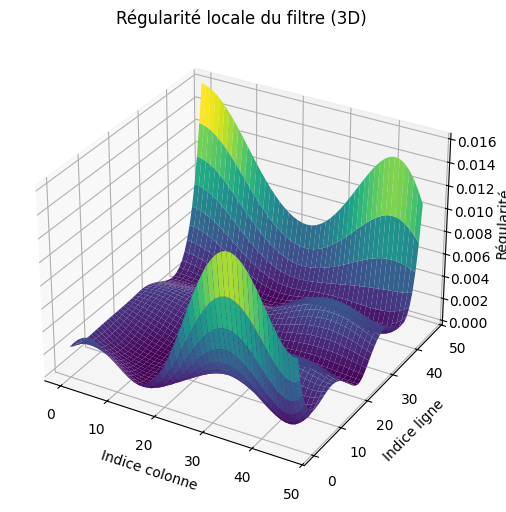

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator


def local_regularity_fourier_3D(h, block_size=(3,3), alpha=2):
    """
    Calcule la régularité locale de sous-blocs d'un filtre 2D
    et prépare une carte de régularité pour visualisation 3D.

    Arguments :
    - h : filtre 2D (numpy array)
    - block_size : tuple (hauteur, largeur) du sous-bloc
    - alpha : puissance pour pondérer les hautes fréquences

    Retour :
    - reg_map : matrice de régularité des sous-blocs
    """
    n, m = h.shape
    bh, bw = block_size
    reg_map = np.zeros((n - bh + 1, m - bw + 1))
    
    for i in range(n - bh + 1):
        for j in range(m - bw + 1):
            block = h[i:i+bh, j:j+bw]
            H = np.fft.fft2(block)
            H = np.fft.fftshift(H)
            
            # grille des fréquences
            u = np.fft.fftshift(np.fft.fftfreq(bh))
            v = np.fft.fftshift(np.fft.fftfreq(bw))
            U, V = np.meshgrid(u, v, indexing='ij')
            
            freq_weight = (U**2 + V**2)**(alpha/2)
            reg_map[i,j] = np.sum(freq_weight * np.abs(H)**2)
    
    return reg_map

# Exemple d'utilisation
 # filtre 2D que tu veux analyser
block_size = (3,3)
alpha = 2

reg_map = local_regularity_fourier_3D(Zsmooth, block_size=block_size, alpha=alpha)

# Affichage 3D
X, Y = np.meshgrid(np.arange(reg_map.shape[1]), np.arange(reg_map.shape[0]))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, reg_map, cmap='viridis')
ax.set_xlabel('Indice colonne')
ax.set_ylabel('Indice ligne')
ax.set_zlabel('Régularité')
ax.set_title("Régularité locale du filtre (3D)")
plt.show()


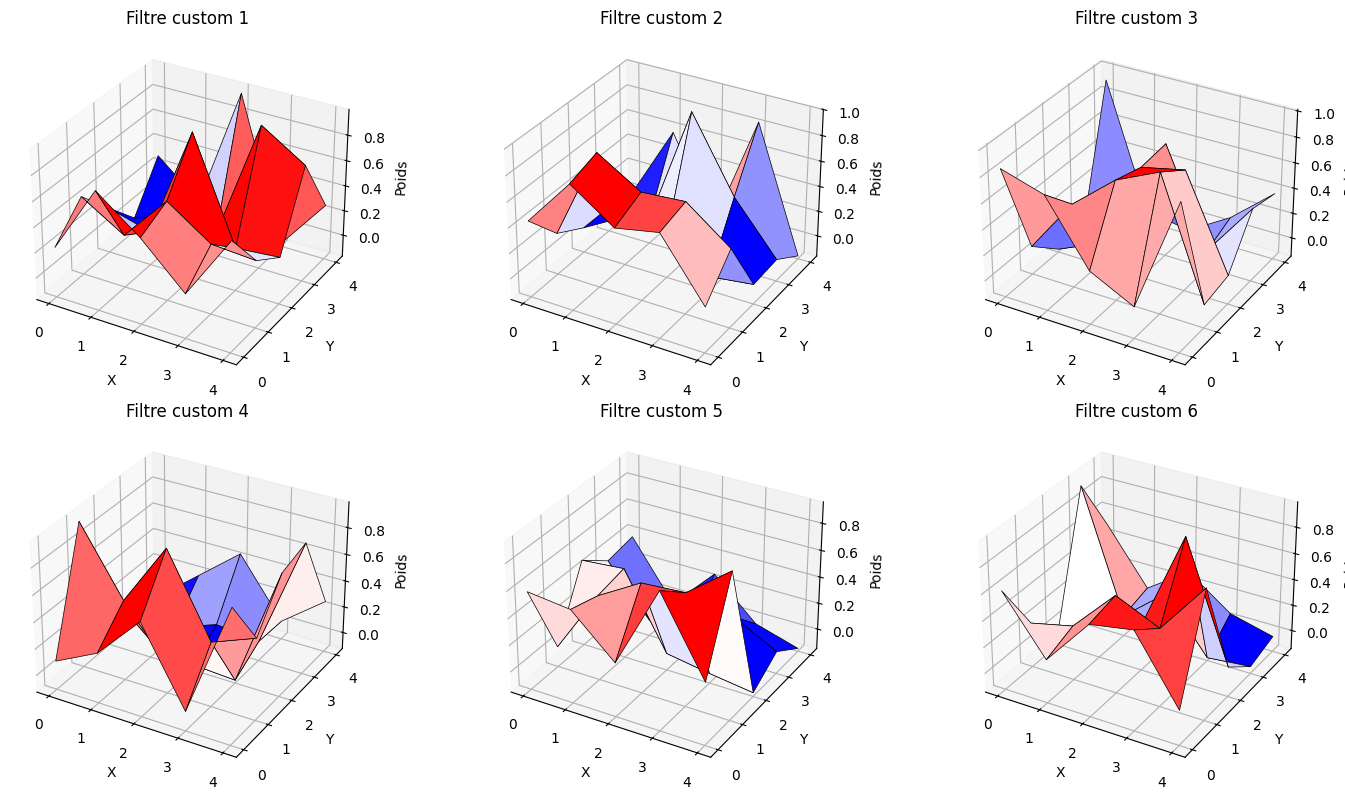

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random

def plot_six_custom_filters(filter_size=5, mu=0.0, sigma=0.1):
    """
    Affiche 6 filtres 3D avec :
    - Première moitié du filtre entièrement aléatoire uniforme
    - Seconde moitié moitié uniforme, moitié gaussienne
    """
    fig = plt.figure(figsize=(15, 8))
    
    for i in range(6):
        filter_weights = np.zeros((filter_size, filter_size))
        half_row = filter_size // 2  # division des lignes
        
        # Première moitié (lignes supérieures) : totalement aléatoire uniforme
        for x in range(half_row):
            for y in range(filter_size):
                filter_weights[x, y] = random.random()
        
        # Seconde moitié (lignes inférieures) : moitié uniforme, moitié gaussienne
        for x in range(half_row, filter_size):
            indices = list(range(filter_size))
            random.shuffle(indices)
            half = filter_size // 2
            uniform_indices = indices[:half]
            gaussian_indices = indices[half:]
            
            for y in uniform_indices:
                filter_weights[x, y] = random.random()
            for y in gaussian_indices:
                filter_weights[x, y] = np.random.normal(mu, sigma)
        
        # Meshgrid pour l'affichage 3D
        h, w = filter_weights.shape
        X, Y = np.meshgrid(np.arange(w), np.arange(h))
        Z = filter_weights
        
        # Ajouter un subplot
        ax = fig.add_subplot(2, 3, i+1, projection="3d")
        ax.plot_surface(X, Y, Z, cmap="bwr", edgecolor="k", linewidth=0.5)
        ax.set_title(f"Filtre custom {i+1}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Poids")
    
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
plot_six_custom_filters()
            

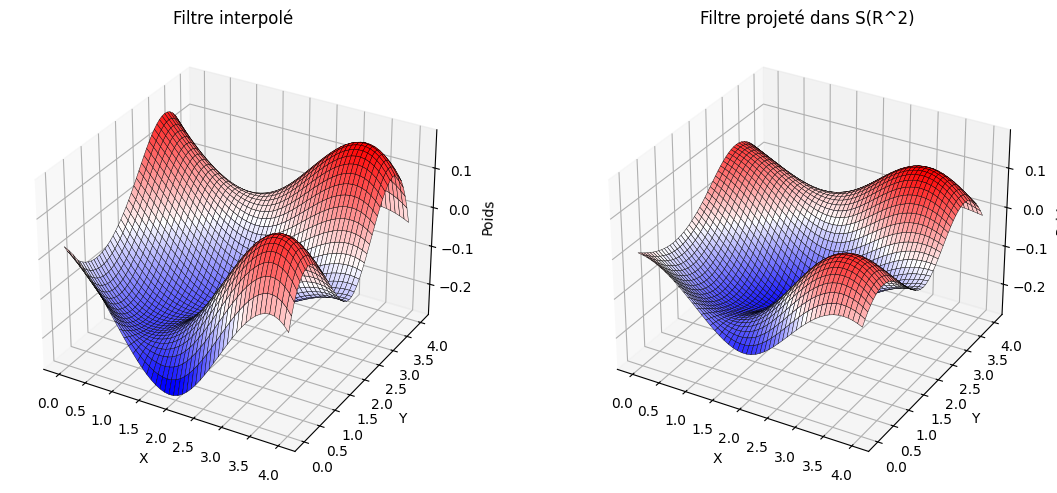

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator

def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique bilinéaire pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return X, Y, Zsmooth

def project_to_schwartz(Zsmooth, sigma=None):
    """Projette un filtre interpolé dans un espace proche de S(R^2) via une fenêtre gaussienne"""
    H, W = Zsmooth.shape
    if sigma is None:
        sigma = min(H, W) / 2
    y = np.arange(H) - H/2
    x = np.arange(W) - W/2
    X, Y = np.meshgrid(x, y)
    gauss_window = np.exp(-(X**2 + Y**2) / (2*sigma**2))
    Z_schwartz = Zsmooth * gauss_window
    return Z_schwartz

def plot_filter_and_schwartz(filter_weights, smooth_factor=50, sigma=None, title="Filtre"):
    """
    Affiche le filtre interpolé et sa projection dans S(R^2) avec la même échelle Z
    """
    # Interpolation
    X, Y, Zsmooth = interpolate_filter(filter_weights, smooth_factor=smooth_factor)
    
    # Projection dans S(R^2)
    Z_schwartz = project_to_schwartz(Zsmooth, sigma=sigma)
    
    # Figure côte à côte
    fig = plt.figure(figsize=(12,5))
    
    # Premier graphique : filtre interpolé
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Zsmooth, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax1.set_title(f"{title} interpolé")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Poids")
    
    # Récupérer les bornes Z
    zmin, zmax = ax1.get_zlim()
    
    # Deuxième graphique : projection
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_schwartz, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax2.set_title(f"{title} projeté dans S(R^2)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Poids")
    ax2.set_zlim(zmin, zmax)  # Appliquer la même échelle
    
    plt.tight_layout()
    plt.show()
    
    return Zsmooth, Z_schwartz

# Exemple d'utilisation
filter_weights = np.array(h)  # Exemple de filtre 6x6 aléatoire
Zsmooth, Z_schwartz = plot_filter_and_schwartz(filter_weights, smooth_factor=50, sigma=25)

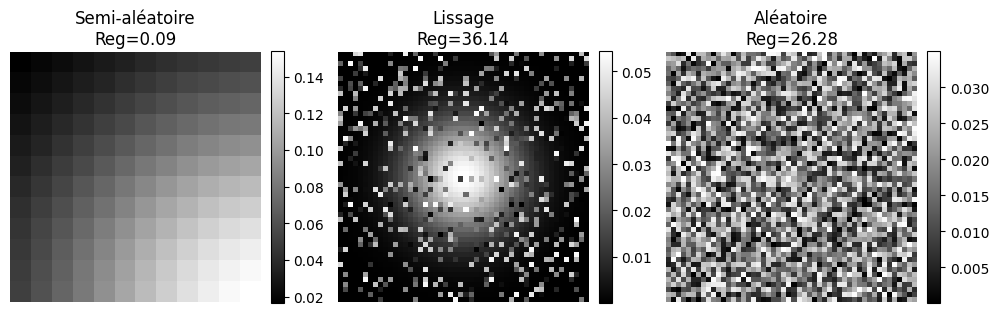

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

def normalize_l2(h):
    return h / np.linalg.norm(h)

def normalize_sum(h):
    return h / np.sum(h)

def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique bilinéaire pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return Zsmooth

def regularity_fourier(h, alpha=4):
    """
    Calcule la régularité d'un filtre 2D h[n,m] via sa transformée de Fourier.
    """
    H = np.fft.fft2(h)
    H = np.fft.fftshift(H)  # recentrer les basses fréquences
    
    n, m = h.shape
    u = np.fft.fftshift(np.fft.fftfreq(n))
    v = np.fft.fftshift(np.fft.fftfreq(m))
    U, V = np.meshgrid(u, v, indexing='ij')
    
    freq_weight = (U**2 + V**2)**(alpha/2)
    reg = np.sum(freq_weight * np.abs(H)**2)
    return reg

def semi_random_filter(size=50, sigma=5):
    """
    Crée un filtre semi-aléatoire :
    - Quart supérieur gauche = gaussienne
    - Autres quarts = bruit aléatoire
    """
    filt = np.random.rand(size, size) * 0.5  # base aléatoire faible
    
    # coordonnées
    x = np.arange(size//4)
    y = np.arange(size//4)
    X, Y = np.meshgrid(x, y)
    
    # gaussienne centrée sur le quart supérieur gauche
    gauss = np.exp(-((X - size//4)**2 + (Y - size//4)**2) / (2*sigma**2))
    
    # insérer la gaussienne dans le quart supérieur gauche
    filt[:size//4, :size//4] = gauss
    
    return filt

# Génération du filtre semi-aléatoire
semi_random= semi_random_filter(size=50, sigma=8)

# Normalisation
filters = {
    "Semi-aléatoire": normalize_l2(gauss),
    "Lissage": normalize_l2(filt_gauss),
    "Aléatoire": normalize_l2(np.random.rand(50,50)),
}

# Calcul des régularités
regularities = {name: regularity_fourier(h) for name, h in filters.items()}

# Affichage
fig, axes = plt.subplots(1, len(filters), figsize=(12,4))
for ax, (name, h) in zip(axes, filters.items()):
    im = ax.imshow(h, cmap='gray', interpolation='nearest')
    ax.set_title(f"{name}\nReg={regularities[name]:.2f}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.show()



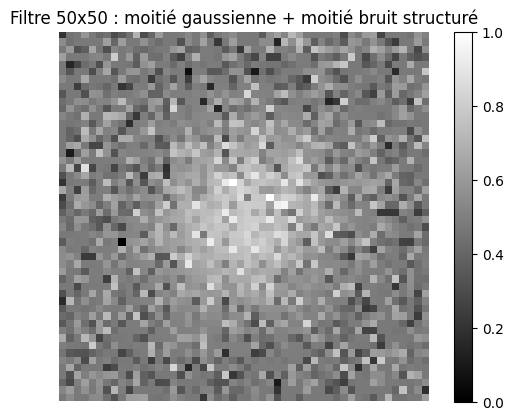

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_2d(size=50, sigma=10):
    """Crée une gaussienne 2D centrée"""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)
    gauss = np.exp(-(X**2 + Y**2) / (2*sigma**2))
    return gauss / np.max(gauss)  # normalisation entre 0 et 1

def gaussian_with_structured_noise(size=50, sigma=10, ratio=0.5, noise_sigma=0.2):
    """
    Crée une gaussienne 2D puis remplace une fraction (ratio) par du bruit
    Le bruit suit une loi normale N(µ, σ²), µ = gauss locale
    """
    gauss = gaussian_2d(size, sigma)
    mask = np.random.rand(size, size) < ratio  # où mettre du bruit
    
    # bruit gaussien centré autour de la valeur de la gaussienne
    noise = gauss + np.random.normal(0, noise_sigma, size=(size, size))
    
    filt = gauss.copy()
    filt[mask] = noise[mask]
    
    # normalisation entre 0 et 1
    filt = (filt - filt.min()) / (filt.max() - filt.min())
    return filt

# Génération
filt_gauss = gaussian_with_structured_noise(size=50, sigma=8, ratio=0.7, noise_sigma=0.4)

# Affichage
plt.imshow(filt_gauss, cmap="gray")
plt.title("Filtre 50x50 : moitié gaussienne + moitié bruit structuré")
plt.axis("off")
plt.colorbar()
plt.show()


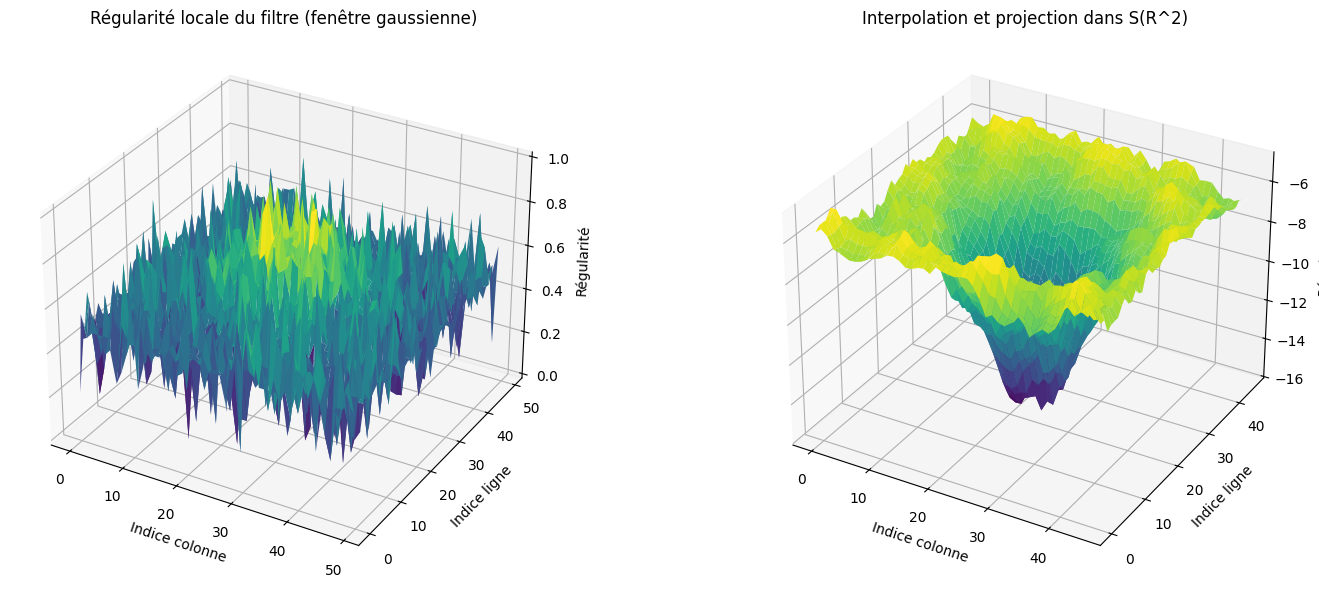

Valeur de régularité sommée : 16392.456557681122


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Zsmooth = interpolate_filter(np.array(h), smooth_factor=50)
Zsmooth = np.array(Zsmooth)
Zsmooth_random = interpolate_filter(np.array(h_random), smooth_factor=50)
Zsmooth_random = np.array(Zsmooth_random)
def gaussian_window(shape, sigma=1.0, center=None):
    """Fenêtre gaussienne normalisée 2D"""
    n, m = shape
    if center is None:
        center = (n//2, m//2)
    y = np.arange(n) - center[0]
    x = np.arange(m) - center[1]
    X, Y = np.meshgrid(x, y)
    g = np.exp(-(X**2 + Y**2)/(2*sigma**2))
    g /= np.sqrt(np.sum(g**2))
    return g

def local_sobolev_gauss_3D(h, block_size=(5,5), alpha=2, sigma=1.0):
    """
    Calcule la régularité locale de sous-blocs d'un filtre 2D
    avec fenêtre gaussienne et pondération Sobolev.

    Retour :
    - reg_map : matrice de régularité locale
    """
    n, m = h.shape
    bh, bw = block_size
    reg_map = np.zeros((n - bh + 1, m - bw + 1))
    
    for i in range(n - bh + 1):
        for j in range(m - bw + 1):
            block = h[i:i+bh, j:j+bw]
            g = gaussian_window(block.shape, sigma=sigma)
            block_win = block * g
            
            H = np.fft.fft2(block_win)
            H = np.fft.fftshift(H)
            
            u = np.fft.fftshift(np.fft.fftfreq(bh))
            v = np.fft.fftshift(np.fft.fftfreq(bw))
            U, V = np.meshgrid(u, v, indexing='ij')
            
            freq_weight = (1 + U**2 + V**2)**alpha
            reg_map[i,j] = np.sum(freq_weight * np.abs(H)**2)
    
    return reg_map

# Exemple d'utilisation
block_size = (5,5)
alpha = 2
sigma = 25

reg_map = local_sobolev_gauss_3D(filt_gauss, block_size=block_size, alpha=alpha, sigma=sigma)

# Affichage côte à côte
fig = plt.figure(figsize=(16,6))

# Premier graphique : régularité locale
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
X1, Y1 = np.meshgrid(np.arange(filt_gauss.shape[1]), np.arange(filt_gauss.shape[0]))
ax1.plot_surface(X1, Y1, filt_gauss, cmap='viridis')
ax1.set_xlabel('Indice colonne')
ax1.set_ylabel('Indice ligne')
ax1.set_zlabel('Régularité')
ax1.set_title("Régularité locale du filtre (fenêtre gaussienne)")

# Deuxième graphique : interpolation et projection
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
X2, Y2 = np.meshgrid(np.arange(reg_map.shape[1]), np.arange(reg_map.shape[0]))
ax2.plot_surface(X2, Y2, -reg_map, cmap='viridis')
ax2.set_xlabel('Indice colonne')
ax2.set_ylabel('Indice ligne')
ax2.set_zlabel('Régularité')
ax2.set_title("Interpolation et projection dans S(R^2)")

plt.tight_layout()
plt.show()

# Identifier les sous-blocs les plus réguliers
print("Valeur de régularité sommée :", np.sum(reg_map))

In [ ]:
import numpy as np

def percentile_mask(reg_map, percentile=10):
    """
    Crée un masque binaire des positions correspondant
    aux p% plus petites valeurs de régularité.
    """
    threshold = np.percentile(reg_map, percentile)
    mask = (reg_map <= percentile).astype(int)
    return mask

def weighted_sum_with_mask(Zsmooth, reg_map, percentile=10, block_size=(3,3)):
    """
    Calcule la somme des poids (|.|) dans Zsmooth
    correspondant aux zones les plus régulières (p%).
    
    Arguments :
    - Zsmooth : filtre 2D
    - reg_map : matrice de régularité locale
    - percentile : seuil pour garder les zones régulières
    - block_size : taille des blocs locaux
    
    Retour :
    - total_sum : somme pondérée sur les zones sélectionnées
    - mask : masque binaire (taille identique à reg_map)
    """
    mask = percentile_mask(reg_map, percentile=percentile)
    bh, bw = block_size
    
    total_sum = 0.0
    for (i, j) in np.argwhere(mask == 1):
        block = Zsmooth[i:i+bh, j:j+bw]
        total_sum += np.sum(np.abs(block))
    
    return total_sum, mask

# Exemple d’utilisation :
percentile = 30  # garder les 20% zones les plus régulières
block_size = (5,5)

# 1. Calculer la carte de régularité locale
reg_map = local_sobolev_gauss_3D(Zsmooth, block_size=block_size, alpha=2, sigma=1.0)

# 2. Calculer la somme pondérée sur les zones régulières
total_sum, mask = weighted_sum_with_mask(Zsmooth, reg_map, percentile=percentile, block_size=block_size)

print(f"Somme des poids absolus sur les {percentile}% zones les plus régulières :", total_sum)


Somme des poids absolus sur les 30% zones les plus régulières : 1998.6633369146825


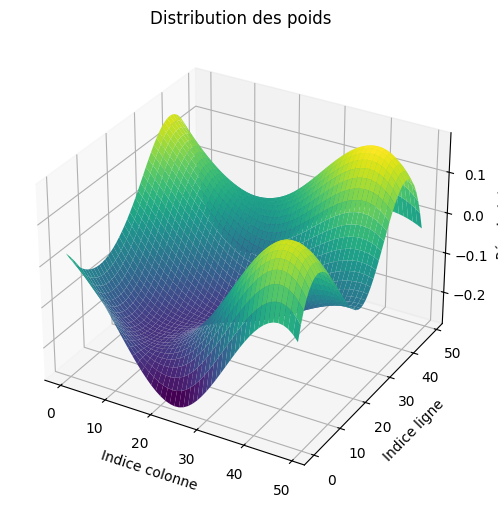

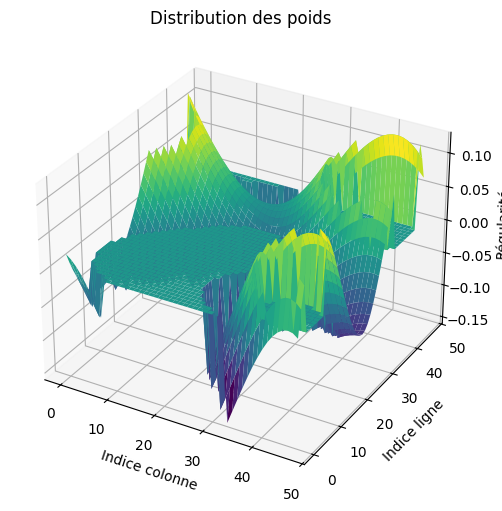

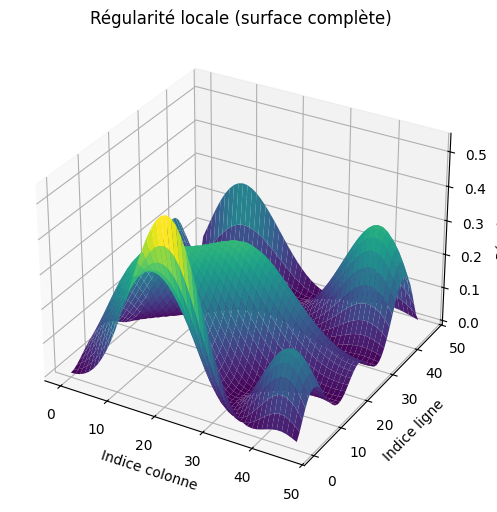

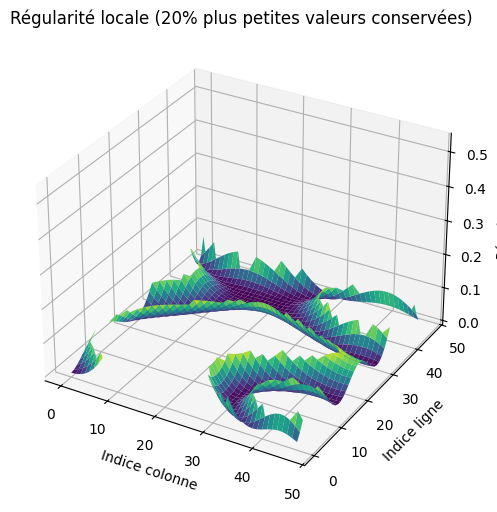

In [120]:
import numpy as np
import matplotlib.pyplot as plt

def graphcut_filter_surface(Zsmooth, percentile=20):
    """
    Conserve uniquement les valeurs les plus petites (en valeur absolue) 
    selon un seuil basé sur le percentile.
    
    Zsmooth : surface lissée (2D numpy array)
    percentile : pourcentage de valeurs à conserver (les plus petites)
    """
    threshold = np.percentile(np.abs(Zsmooth), percentile)
    mask = np.abs(Zsmooth) <= threshold  # True là où on garde
    Zcut = np.where(mask, Zsmooth, np.nan)  # NaN pour visualiser les trous
    return Zcut, mask

# Application sur reg_map
Zcut, mask = graphcut_filter_surface(reg_map, percentile=50)


X, Y = np.meshgrid(np.arange(Zsmooth.shape[1]), np.arange(Zsmooth.shape[0]))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf2 = ax.plot_surface(X, Y, Zsmooth, cmap='viridis')
ax.set_xlabel('Indice colonne')
ax.set_ylabel('Indice ligne')
ax.set_zlabel('Régularité')
ax.set_title("Distribution des poids")
zmin, zmax = ax.get_zlim()
plt.show()
Zmask = mask * Zsmooth[:Zmask.shape[0], :Zmask.shape[1]]
X, Y = np.meshgrid(np.arange(Zmask.shape[1]), np.arange(Zmask.shape[0]))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf2 = ax.plot_surface(X, Y, Zmask, cmap='viridis')
ax.set_xlabel('Indice colonne')
ax.set_ylabel('Indice ligne')
ax.set_zlabel('Régularité')
ax.set_title("Distribution des poids")
zmin, zmax = ax.get_zlim()
plt.show()
# Premier plot : surface originale
X, Y = np.meshgrid(np.arange(reg_map.shape[1]), np.arange(reg_map.shape[0]))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf1 = ax.plot_surface(X, Y, reg_map, cmap='viridis')
ax.set_xlabel('Indice colonne')
ax.set_ylabel('Indice ligne')
ax.set_zlabel('Régularité')
ax.set_title("Régularité locale (surface complète)")
zmin, zmax = ax.get_zlim()  # récupérer les bornes Z
plt.show()

# Deuxième plot : surface filtrée avec même échelle Z
X, Y = np.meshgrid(np.arange(Zcut.shape[1]), np.arange(Zcut.shape[0]))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf2 = ax.plot_surface(X, Y, Zcut, cmap='viridis')
ax.set_xlabel('Indice colonne')
ax.set_ylabel('Indice ligne')
ax.set_zlabel('Régularité')
ax.set_title("Régularité locale (20% plus petites valeurs conservées)")
ax.set_zlim(zmin, zmax)  # appliquer la même échelle
plt.show()


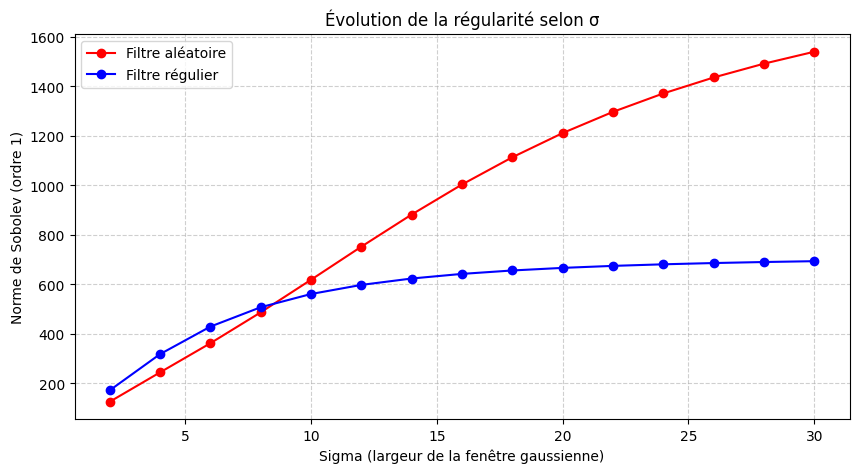

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# --- Fonctions utilitaires ---

def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h - 1, smooth_factor)
    xnew = np.linspace(0, w - 1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return Zsmooth


def project_to_schwartz(Zsmooth, sigma):
    """Projection dans un espace proche de S(R^2) via une gaussienne de largeur sigma"""
    H, W = Zsmooth.shape
    y = np.arange(H) - H / 2
    x = np.arange(W) - W / 2
    X, Y = np.meshgrid(x, y)
    gauss_window = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    Z_schwartz = Zsmooth * gauss_window
    return Z_schwartz


def sobolev_norm(Z, alpha=1.0):
    """Calcule la norme de Sobolev d'ordre alpha"""
    H = np.fft.fftshift(np.fft.fft2(Z))
    n, m = Z.shape
    u = np.fft.fftshift(np.fft.fftfreq(n))
    v = np.fft.fftshift(np.fft.fftfreq(m))
    U, V = np.meshgrid(u, v, indexing='ij')
    weight = (1 + U**2 + V**2)**alpha
    return np.sqrt(np.sum(weight * (np.abs(H)**2)))


def sweep_sigma(filter_weights, sigmas, smooth_factor=50, alpha=1.0):
    """Balaye les sigma et calcule la norme Sobolev correspondante"""
    Zsmooth = interpolate_filter(filter_weights, smooth_factor=smooth_factor)
    norms = []
    for sigma in sigmas:
        Z_schwartz = project_to_schwartz(Zsmooth, sigma)
        norm_val = sobolev_norm(Z_schwartz, alpha=alpha)
        norms.append(norm_val)
    return np.array(norms)


# --- Exemple d'utilisation ---

# Filtre aléatoire (bruyant)
np.random.seed(0)
filter_random = np.random.randn(5, 5)

# Filtre régulier (type gaussien)
x = np.linspace(-1, 1, 5)
y = np.linspace(-1, 1, 5)
X, Y = np.meshgrid(x, y)
filter_regular = np.exp(-(X**2 + Y**2) / 0.2)

# Liste des sigma à tester
sigmas = np.linspace(2, 30, 15)

# Calcul des normes Sobolev
norms_random = sweep_sigma(filter_random, sigmas)
norms_regular = sweep_sigma(filter_regular, sigmas)

# --- Affichage des résultats ---

plt.figure(figsize=(10,5))
plt.plot(sigmas, norms_random, 'r-o', label='Filtre aléatoire')
plt.plot(sigmas, norms_regular, 'b-o', label='Filtre régulier')
plt.xlabel('Sigma (largeur de la fenêtre gaussienne)')
plt.ylabel('Norme de Sobolev (ordre 1)')
plt.title("Évolution de la régularité selon σ")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# --- Fonctions utilitaires ---

def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h - 1, smooth_factor)
    xnew = np.linspace(0, w - 1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return Zsmooth

def project_to_schwartz(Zsmooth, sigma):
    """Projection dans un espace proche de S(R^2) via une gaussienne de largeur sigma"""
    H, W = Zsmooth.shape
    y = np.arange(H) - H / 2
    x = np.arange(W) - W / 2
    X, Y = np.meshgrid(x, y)
    gauss_window = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return Zsmooth * gauss_window

def sobolev_norm(Z, alpha=1.0):
    """Calcule la norme de Sobolev d'ordre alpha"""
    H = np.fft.fftshift(np.fft.fft2(Z))
    n, m = Z.shape
    u = np.fft.fftshift(np.fft.fftfreq(n))
    v = np.fft.fftshift(np.fft.fftfreq(m))
    U, V = np.meshgrid(u, v, indexing='ij')
    weight = (1 + U**2 + V**2)**alpha
    return np.sqrt(np.sum(weight * (np.abs(H)**2)))

def sweep_sigma(filter_weights, sigmas, smooth_factor=50, alpha=1.0):
    """Balaye les sigma et calcule la norme Sobolev correspondante"""
    Zsmooth = interpolate_filter(filter_weights, smooth_factor=smooth_factor)
    norms = []
    for sigma in sigmas:
        Z_schwartz = project_to_schwartz(Zsmooth, sigma)
        norm_val = sobolev_norm(Z_schwartz, alpha=alpha)
        norms.append(norm_val)
    return np.array(norms)

# --- Extraction des filtres du modèle ---

def get_conv_filters(model):
    """Extrait tous les filtres (2D) d’un modèle PyTorch"""
    conv_filters = []
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            w = module.weight.data.cpu().numpy()
            for oc in range(w.shape[0]):
                for ic in range(w.shape[1]):
                    conv_filters.append(w[oc, ic])
    return conv_filters

# --- Analyse comparative ---

def compare_filters_sobolev(model, n_random=10, n_model=10, sigmas=np.linspace(2, 30, 15)):
    conv_filters = get_conv_filters(model)
    print(f"{len(conv_filters)} filtres extraits du modèle.")

    # Sélection aléatoire de filtres du modèle
    selected_filters = [conv_filters[i] for i in np.random.choice(len(conv_filters), n_model, replace=False)]

    # Génération de filtres aléatoires (même taille que les filtres du modèle)
    k = selected_filters[0].shape[0]
    random_filters = [np.random.randn(k, k) for _ in range(n_random)]

    # Calcul des normes
    model_norms = [sweep_sigma(f, sigmas) for f in selected_filters]
    random_norms = [sweep_sigma(f, sigmas) for f in random_filters]

    # --- Affichage ---
    plt.figure(figsize=(10,5))
    for norms in random_norms:
        plt.plot(sigmas, norms, 'r-', alpha=0.5)
    for norms in model_norms:
        plt.plot(sigmas, norms, 'b-', alpha=0.5)
    plt.xlabel('Sigma')
    plt.ylabel('Norme de Sobolev')
    plt.title("Comparaison des régularités entre filtres aléatoires (rouge) et filtres appris (bleu)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# --- Exemple d’utilisation ---
compare_filters_sobolev(model)



KeyboardInterrupt



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# --- Fonctions utilitaires ---

def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h - 1, smooth_factor)
    xnew = np.linspace(0, w - 1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return Zsmooth

def project_to_schwartz(Zsmooth, sigma):
    """Projection dans un espace proche de S(R^2) via une gaussienne de largeur sigma"""
    H, W = Zsmooth.shape
    y = np.arange(H) - H / 2
    x = np.arange(W) - W / 2
    X, Y = np.meshgrid(x, y)
    gauss_window = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return Zsmooth * gauss_window

def sobolev_norm(Z, alpha=2.0):
    """Calcule la norme de Sobolev d'ordre alpha"""
    H = np.fft.fftshift(np.fft.fft2(Z))
    n, m = Z.shape
    u = np.fft.fftshift(np.fft.fftfreq(n))
    v = np.fft.fftshift(np.fft.fftfreq(m))
    U, V = np.meshgrid(u, v, indexing='ij')
    weight = (1 + U**2 + V**2)**alpha
    return np.sqrt(np.sum(weight * (np.abs(H)**2)))

def sweep_sigma(filter_weights, sigmas, smooth_factor=50, alpha=2.0):
    """Balaye les sigma et calcule la norme Sobolev correspondante"""
    Zsmooth = interpolate_filter(filter_weights, smooth_factor=smooth_factor)
    norms = []
    for sigma in sigmas:
        Z_schwartz = project_to_schwartz(Zsmooth, sigma)
        norm_val = sobolev_norm(Z_schwartz, alpha=alpha)
        norms.append(norm_val)
    return np.array(norms)

def get_conv_filters(model):
    """Extrait tous les filtres 2D d’un modèle PyTorch"""
    conv_filters = []
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            w = module.weight.data.cpu().numpy()
            for oc in range(w.shape[0]):
                for ic in range(w.shape[1]):
                    conv_filters.append(w[oc, ic])
    return conv_filters

# --- Sélection intelligente des filtres du modèle ---

def select_representative_filters(model, sigma_ref=10, alpha=1.0, n_each=10):
    """Sélectionne les filtres les plus réguliers et les plus irréguliers du modèle"""
    conv_filters = get_conv_filters(model)
    print(f"{len(conv_filters)} filtres extraits du modèle.")

    norms = []
    for f in conv_filters:
        Zsmooth = interpolate_filter(f, smooth_factor=40)
        Z_schwartz = project_to_schwartz(Zsmooth, sigma_ref)
        norm_val = sobolev_norm(Z_schwartz, alpha=alpha)
        norms.append(norm_val)

    norms = np.array(norms)
    idx_sorted = np.argsort(norms)
    
    regular_filters = [conv_filters[i] for i in idx_sorted[:n_each]]    # plus réguliers
    irregular_filters = [conv_filters[i] for i in idx_sorted[-n_each:]] # plus bruités

    print(f"Régularité moyenne (min / max): {norms.min():.2f} / {norms.max():.2f}")
    return regular_filters, irregular_filters

# --- Analyse comparative ---

def compare_filters_sobolev(model, n_random=30, n_model=15, sigmas=np.linspace(2, 100, 15)):
    conv_filters = get_conv_filters(model)
    print(f"{len(conv_filters)} filtres extraits du modèle.")

    # Sélection aléatoire de filtres du modèle
    selected_filters = [conv_filters[i] for i in np.random.choice(len(conv_filters), n_model, replace=False)]

    # Génération de filtres aléatoires (même taille que les filtres du modèle)
    k = selected_filters[0].shape[0]
    random_filters = [np.random.randn(k, k) for _ in range(n_random)]

    # Calcul des normes
    model_norms = [sweep_sigma(f, sigmas) for f in selected_filters]
    random_norms = [sweep_sigma(f, sigmas) for f in random_filters]

    plt.figure(figsize=(12,6))

    # --- Filtres aléatoires ---
    for norms in random_norms:
        plt.plot(sigmas, norms, 'r-', alpha=0.5)
        max_val = norms.max()
        threshold = max_val * 0.95
        # sigma à partir duquel la norme >= 95% max
        idx = np.argmax(norms >= threshold)
        sigma_5pct = sigmas[idx]
        plt.plot(sigma_5pct, norms[idx], 'ro')  # point rouge
        plt.text(sigma_5pct, norms[idx], f"{sigma_5pct:.1f}", color='red', fontsize=8)

    # --- Filtres appris ---
    for norms in model_norms:
        plt.plot(sigmas, norms, 'b-', alpha=0.5)
        max_val = norms.max()
        threshold = max_val * 0.95
        idx = np.argmax(norms >= threshold)
        sigma_5pct = sigmas[idx]
        plt.plot(sigma_5pct, norms[idx], 'bo')  # point bleu
        plt.text(sigma_5pct, norms[idx], f"{sigma_5pct:.1f}", color='blue', fontsize=8)

    plt.xlabel('Sigma')
    plt.ylabel('Norme de Sobolev')
    plt.title("Comparaison des régularités entre filtres aléatoires (rouge) et filtres appris (bleu)\n"
              "Points : Sigma à 95% de la norme max")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# --- Exemple d’utilisation ---
# compare_filters_sobolev(model)


**Analyse avant fine tuning**


In [ ]:
from scipy.stats import pearsonr

X = [10,10,12.69,10.45,16.17,31,63.39,75.33,81.42]
Y = [10,10,10.33,10.23,14.23,34.46,53.82,68.38,76.5]
r, p_value = pearsonr(X, Y)
print(f"Coefficient de corrélation de Pearson : r = {r:.4f}, p-value = {p_value:.4e}")


Coefficient de corrélation de Pearson : r = 0.9950, p-value = 2.8999e-08


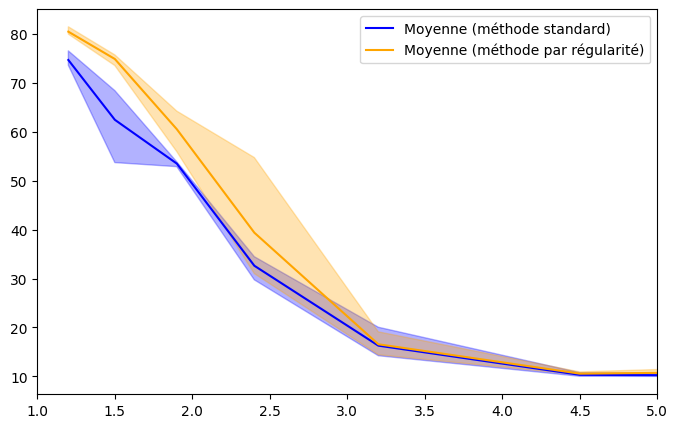

RMSE globale = 3.8934560482943685


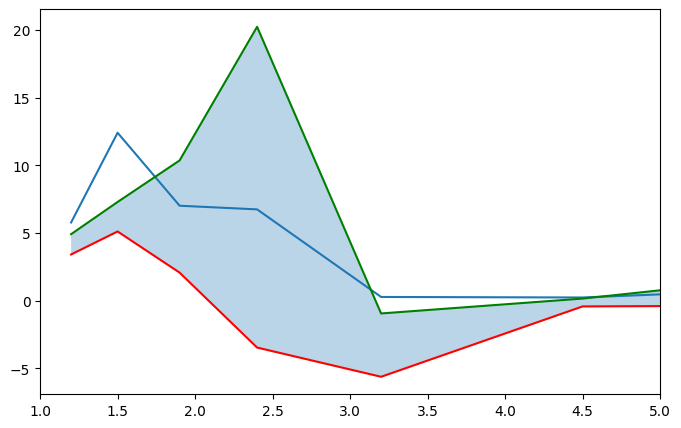

3.7095370370370375
4.845555555555556
4.2170165114554035


In [95]:
import numpy as np
import matplotlib.pyplot as plt

# 4 vecteurs de même longueur
x = list(reversed([1.2,1.5,1.9,2.4,3.2,4.5,6.3,9.2,12.8]))
v1 = np.array([10,10,9.95,10.3,15.42,34.37,52.85,63.76,74.35])
v2 = np.array([10,10,10.33,10.23,14.23,34.46,53.82,68.38,76.5])
v3 = np.array([10,10.81,9.99,10.76,15.46,31.88,53.49,63.86,73.55])
v4 = np.array([10,9.93,10,10.03,20.05,29.73,53.72,53.68,74.14])

p_20 = np.array([10,10.01,10,11.56,18.04,30.98,55,74.98,79.46])
p_40 = np.array([10,11.57,10.99,12.84,16.36,31.16,55.45,69.95,79.05])
p_60 = np.array([10,10,10,10.34,14.43,32.38,55.9,73.5,79.92])
p_80 = np.array([10,10,12.69,10.45,16.17,31,61.39,75.33,81.42])
p_100 = np.array([10,10,10.73,10.92,19.11,54.71,64.19,75.68,79.92])

# On les empile : forme (n_courbes, n_points)
curves = np.vstack([v1, v2, v3, v4])
pruning = np.vstack([p_60, p_80, p_100])

# Calcul de la moyenne et des bornes min/max
mean_curve = np.mean(curves, axis=0)
min_curve = np.min(curves, axis=0)
max_curve = np.max(curves, axis=0)

mean_pruning = np.mean(pruning, axis=0)
min_pruning = np.min(pruning, axis=0)
max_pruning = np.max(pruning, axis=0)

difference = mean_curve - mean_pruning 
# Tracé
plt.figure(figsize=(8,5))

# Courbes moyennes
plt.plot(x, mean_curve, label="Moyenne (méthode standard)", color="blue")
plt.plot(x, mean_pruning, label="Moyenne (méthode par régularité)", color="orange")

# Canaux : entre min et max
plt.fill_between(x, min_curve, max_curve, alpha=0.3, color="blue")
plt.fill_between(x, min_pruning, max_pruning, alpha=0.3, color='orange')

plt.xlim(1,5)
plt.legend()
plt.show()
rmse_global = np.sqrt(np.mean((pruning - mean_pruning) ** 2))

print("RMSE globale =", rmse_global)
plt.figure(figsize=(8,5))
diff = mean_pruning-mean_curve
plt.plot(x,diff)
min_mask = min_pruning-max_curve
max_mask = max_pruning-max_curve




#min_mask = min_mask >0
plt.plot(x,min_mask,color="red")
plt.plot(x,max_mask,color="green")
plt.fill_between(x, min_mask, max_mask, alpha=0.3)
plt.xlim(1,5)
plt.show()

print(np.mean(diff))
print(np.mean(max_mask))
print(np.sqrt(np.mean((diff - np.mean(diff)) ** 2)))

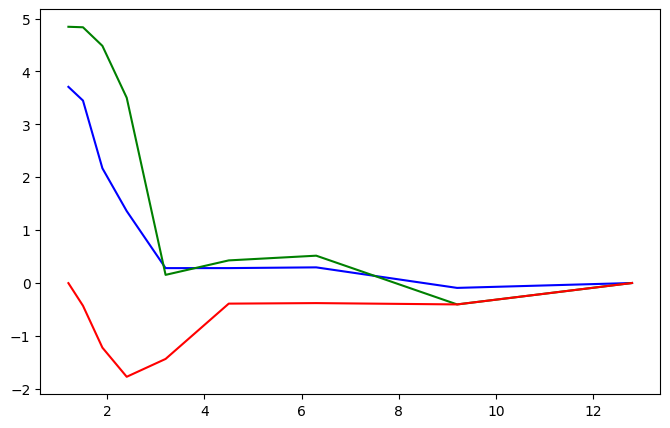

In [100]:
mean_curve_mean = [np.mean(diff[0:i+1]) for i in range(len(diff))]
mean_curve_max = [np.mean(max_mask[0:i+1]) for i in range(len(diff))]
mean_curve_min = [np.mean(min_mask[0:i+1]) for i in range(len(diff))]

plt.figure(figsize=(8,5))
plt.plot(x,mean_curve_mean,color="blue")
plt.plot(x,mean_curve_max,color="green")
plt.plot(x,mean_curve_min,color="red")

plt.show()

Analyse après fine tuning

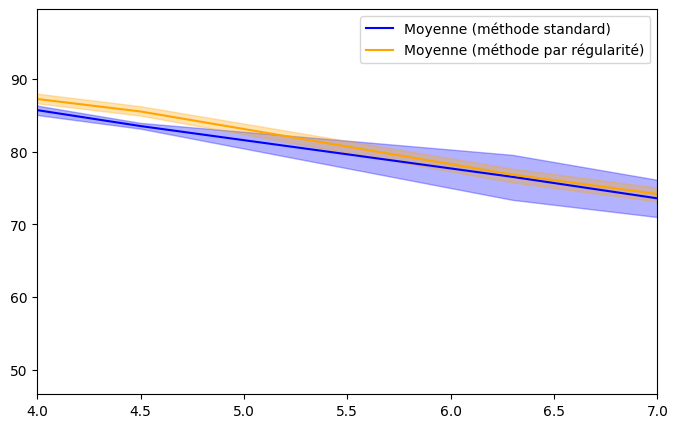

RMSE globale régularité = 0.65073557619317
RMSE globale standard =  0.9927525567274503
Pente d'accuracy pour les modèles standards  = -3.9836316961143194
Pente d'accuracy pour les modèles de régularité  = -3.871453963114182


/tmp/ipykernel_2582/2058098900.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


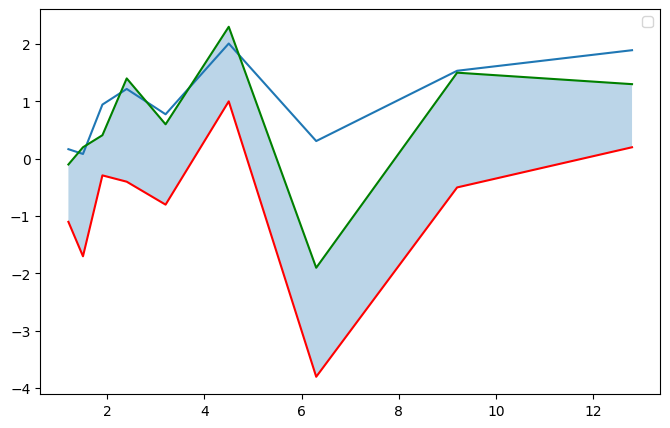

0.9919444444444454
0.6839003970509319


In [90]:
p_20 = np.array([50.2,65.5,84,84.3,89.2,92.6,92.3,94.5,98.5])
p_40 = np.array([52.1,64.3,76.1,86.4,91,92.8,93.5,95.1,95.8])
p_60 = np.array([52.5,66.8,75.7,85.5,89.3,93.8,94.2,94.6,97.1])
p_80 = np.array([53,65.9,77.2,86.2,90,92,94.6,96.4,96.1])
p_100 = np.array([51.9,64.8,77.6,84.9,90.7,92.2,94.9,96.5,96.5])

L1 = np.array([51.7,65.3,76.3,83.9,88,90.6,92.9,95.1,95.4])
L2 = np.array([51.2,64.7,77,83.4,89.5,91.6,92.7,95.6,96.5])
random_pr = np.array([49,63.5,79.5,83.7,90.1,91.2,94.4,96.3,97.2])
variance = np.array([50.4,63.7,73.3,83.1,89.3,92.4,94.49,96,96.5])

curves = np.vstack([L1, L2, variance, random_pr])
pruning = np.vstack([p_60, p_80, p_100])

# Calcul de la moyenne et des bornes min/max
mean_curve = np.mean(curves, axis=0)
min_curve = np.min(curves, axis=0)
max_curve = np.max(curves, axis=0)

mean_pruning = np.mean(pruning, axis=0)
min_pruning = np.min(pruning, axis=0)
max_pruning = np.max(pruning, axis=0)

# Tracé
plt.figure(figsize=(8,5))

# Courbes moyennes
plt.plot(x, mean_curve, label="Moyenne (méthode standard)", color="blue")
plt.plot(x, mean_pruning, label="Moyenne (méthode par régularité)", color="orange")

# Canaux : entre min et max
plt.fill_between(x, min_curve, max_curve, alpha=0.3, color="blue")
plt.fill_between(x, min_pruning, max_pruning, alpha=0.3, color='orange')

plt.xlim(4,7)
plt.legend()
plt.show()

rmse_global = np.sqrt(np.mean((pruning - mean_pruning) ** 2))

print("RMSE globale régularité =", rmse_global)

rmse_global = np.sqrt(np.mean((curves - mean_curve) ** 2))

print("RMSE globale standard = ", rmse_global)

m, b = np.polyfit(x, mean_curve, 1)
print("Pente d'accuracy pour les modèles standards  =", m)
m, b = np.polyfit(x, mean_pruning, 1)
print("Pente d'accuracy pour les modèles de régularité  =", m)

plt.figure(figsize=(8,5))
diff = mean_pruning-mean_curve
plt.plot(x,diff)
min_mask = min_pruning-max_curve
max_mask = max_pruning-max_curve




#min_mask = min_mask >0
plt.plot(x,min_mask,color="red")
plt.plot(x,max_mask,color="green")

plt.fill_between(x, min_mask, max_mask, alpha=0.3)
plt.legend()
plt.show()
print(np.mean(diff))
print(np.sqrt(np.mean((diff - np.mean(diff)) ** 2)))

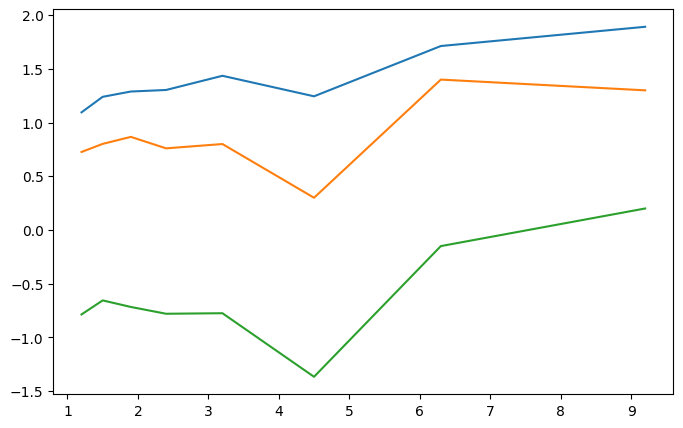

In [ ]:
mean_curve_mean = [np.mean(diff[0:i]) for i in range(len(diff))]
mean_curve_max = [np.mean(max_mask[0:i]) for i in range(len(diff))]
mean_curve_min = [np.mean(min_mask[0:i]) for i in range(len(diff))]

plt.figure(figsize=(8,5))
plt.plot(x,mean_curve_mean)
plt.plot(x,mean_curve_max)
plt.plot(x,mean_curve_min)

plt.show()

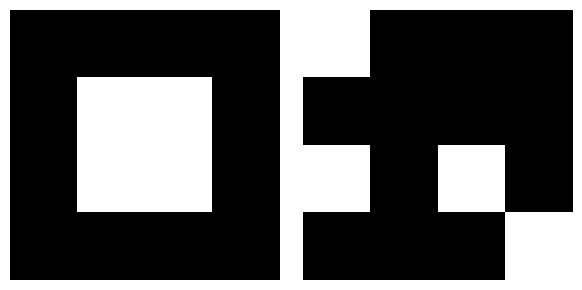

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Image 1 : "rond" blanc (carré 2x2 centré)
image1 = np.zeros((4, 4))
image1[1:3, 1:3] = 1

# Image 2 : pixels blancs aléatoires
np.random.seed(42)
image2 = np.zeros((4, 4))
rows, cols = np.random.choice(4, size=4, replace=True), np.random.choice(4, size=4, replace=True)
image2[rows, cols] = 1

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(image1, cmap='gray', vmin=0, vmax=1)
axes[0].axis('off')
axes[1].imshow(image2, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
plt.tight_layout()
plt.show()
